# ADVERSARIAL EXAMPLE GENERATION
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv

plt.ion()

is_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if is_gpu else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [2]:
mnist_dataset = tv.datasets.MNIST('./data', 
    train=False, 
    download=True,
    transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model_path = os.path.join('.', 'data', 'lenet_mnist_model.pth')

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [6]:
model.load_state_dict(torch.load(pretrained_model_path, map_location='cpu'))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# compute accuracy on clean inputs
test_loader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size=32,
    shuffle=True)
correct = 0

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(target.view_as(pred)).sum().item()

accuracy = correct / len(test_loader.dataset)
print(f'Accuracy on test set = {accuracy*100.:.4f}%')

Accuracy on test set = 98.1000%


In [8]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [9]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                sample_tuple = (init_pred.item(), final_pred.item(), adv_ex)
                adv_examples.append(sample_tuple)
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                sample_tuple = (init_pred.item(), final_pred.item(), adv_ex)
                adv_examples.append(sample_tuple)

    final_acc = correct/float(len(test_loader))
    print("Epsilon = {} - Test Accuracy = {}/{} = {:.4f}%".format(
        epsilon, 
        correct, 
        len(test_loader), 
        final_acc*100.))
    return final_acc, adv_examples

In [10]:
# gradient should based on single input
test_loader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size=1,
    shuffle=True)

accuracies = []
examples = []
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon = 0 - Test Accuracy = 9810/10000 = 98.1000%
Epsilon = 0.05 - Test Accuracy = 9426/10000 = 94.2600%
Epsilon = 0.1 - Test Accuracy = 8510/10000 = 85.1000%
Epsilon = 0.15 - Test Accuracy = 6826/10000 = 68.2600%
Epsilon = 0.2 - Test Accuracy = 4303/10000 = 43.0300%
Epsilon = 0.25 - Test Accuracy = 2087/10000 = 20.8700%
Epsilon = 0.3 - Test Accuracy = 871/10000 = 8.7100%


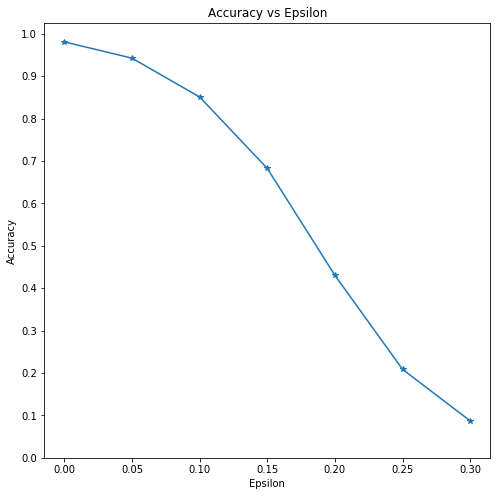

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(epsilons, accuracies, '*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

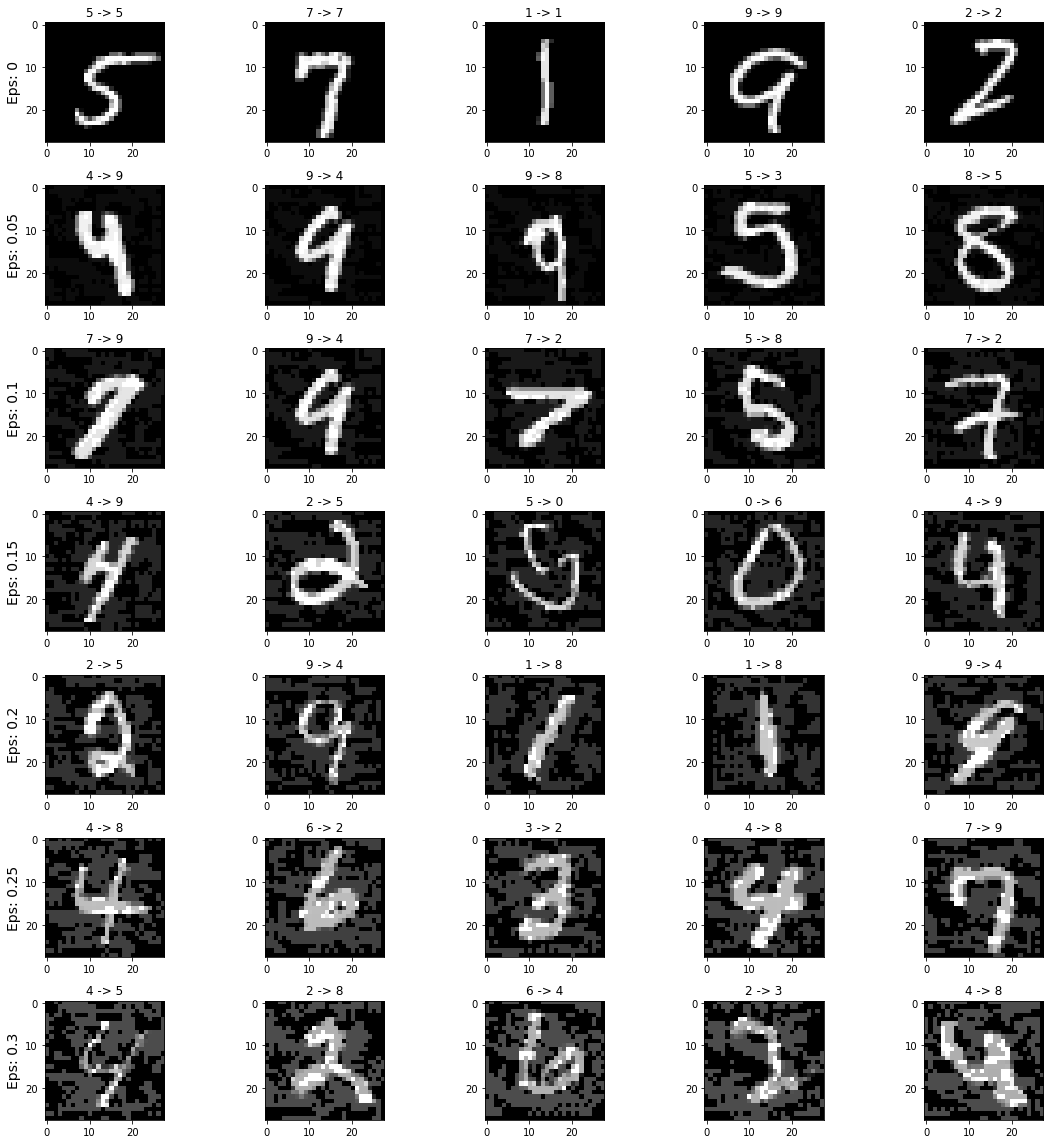

In [12]:
count = 0
plt.figure(figsize=(16,16))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        ax = plt.subplot(len(epsilons),len(examples[0]),count)
        if j == 0:
            ax.set_ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()